In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os

In [2]:
LABELS = \
  [ "T-shirt/top"
  , "Trouser"
  , "Pullover"
  , "Dress"
  , "Coat"
  , "Sandal"
  , "Shirt"
  , "Sneaker"
  , "Bag"
  , "Ankle boot"
  ]

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test  = x_test.astype(np.float32) / 255.

x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

In [4]:
def get_random_inputs (xs, ys, n=1):
    indicies = np.random.choice(xs.shape[0], size=n)
    sample_x = xs[indicies]
    sample_y = ys[indicies]
  
    return sample_x, sample_y

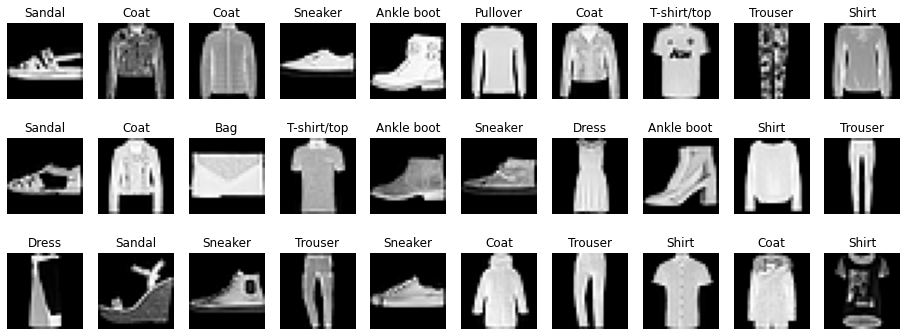

In [5]:
def plot_images_from (xs, ys):
    fig     = plt.figure(figsize=(16, 6))
    columns = 10
    rows    = 3
  
    sample_x, sample_y = get_random_inputs(xs, ys, n=rows*columns)

    for i in range(columns*rows):
        image = sample_x[i]
        label = LABELS[sample_y[i]]

        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title(label)
        ax.axis("off")
        ax.imshow(image.squeeze(), cmap="gray")

# plot_images_from(x_train, y_train)
plot_images_from(x_test, y_test)

# Let's train now

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPool2D, Flatten, Reshape, Dense

In [7]:
net = Sequential()
net.add(Conv2D(input_shape=(28, 28, 1), filters=16, strides=1, kernel_size=3, padding="same", activation="tanh"))
net.add(MaxPool2D(pool_size=2))
net.add(Conv2D(filters=32, strides=1, kernel_size=3, padding="same", activation="tanh"))
net.add(MaxPool2D(pool_size=2))
net.add(Flatten())
net.add(Dense(10, activation="tanh", name="z"))
net.add(Dense(7*7*32, activation="tanh")) #
net.add(Reshape((7, 7, 32)))
net.add(UpSampling2D(size=2))
net.add(Conv2D(filters=16, strides=1, kernel_size=3, padding="same", activation="tanh")) # 14x14x16
net.add(UpSampling2D(size=2)) # 28x28x16
net.add(Conv2D(filters=1, strides=1, kernel_size=3, padding="same", activation="tanh")) # 28x28x1


def loss (y_true, y_pred):
    """ This loss computes the squared difference between the predicted and
        true value; averaged across the batch.
    """
    result     = (y_true - y_pred) ** 2
    loss_batch = tf.math.reduce_sum(result, axis=-1)
    mean_loss  = tf.math.reduce_mean(loss_batch)
    return mean_loss


net.compile( loss = loss
           , optimizer=tf.keras.optimizers.Adam(0.001) )


from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, ModelCheckpoint

nows   = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = f"./logs/{nows}"

print(f"logdir={logdir}")

callbacks = [ TensorBoard( logdir
                         , update_freq='batch'
                         , write_graph=True)
            ]

net.summary()

logdir=./logs/20200311-203307
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
z (Dense)                    (None, 10)                15690     
_________________________________________________________________
dense (Dense)             

In [8]:
base_path = f"{logdir}/embedding"

os.makedirs(base_path) 
os.makedirs(f"{logdir}/ckpt") 

from tensorboard.plugins import projector
from PIL import Image

def log_embedding (logs):
    """ Giant hack for plotting the embedding.
    
    Based partly on: https://github.com/tensorflow/tensorboard/issues/2471
    """
    xs, ys = get_random_inputs(x_test, y_test, n=500)
    
    make_sprite = True
    if make_sprite:
        grid = int(np.sqrt(len(xs))) + 1

        image_height = xs.shape[1]
        image_width  = xs.shape[2]

        sprite = Image.new(mode="RGB", size=(image_width * grid, image_height * grid))

        for i, img in enumerate(xs):
            row = i // grid
            col = i % grid
            img = Image.fromarray(255 - (img.squeeze() * 255))
            img = img.resize((image_height, image_width), Image.ANTIALIAS)
            row_loc = int(row * image_height)
            col_loc = int(col * image_width)
            sprite.paste(img, (col_loc, row_loc)) 

        sprite_path = f"{base_path}/sprite_image.jpg"
        sprite.save(sprite_path)
    
    metadata_path = f"{base_path}/metadata.tsv"
    with open(metadata_path, "w") as f:
        f.write("class\tname\n")
        for y in ys:
            label = LABELS[y]
            f.write(f"{y}\t{label}\n")
    
    
    from tensorflow.keras import Model

    eval_model = Model( net.input, outputs=[net.get_layer("z").output])
    embedding  = eval_model.predict(xs)
    
    config = projector.ProjectorConfig()
    proj = config.embeddings.add()
    
    proj.tensor_name   = "z"
    proj.metadata_path = "metadata.tsv"

    if make_sprite:
        proj.sprite.image_path = "sprite_image.jpg"
        proj.sprite.single_image_dim.extend([image_height, image_width])
    
    projector.visualize_embeddings(base_path, config)
    
    tensor_embeddings = tf.Variable(embedding, name=proj.tensor_name)
    saver = tf.compat.v1.train.Saver([tensor_embeddings])  # Must pass list or dict
    saver.save(sess=None, save_path=f"{base_path}/{proj.tensor_name}.ckpt")
    
    writer = tf.summary.create_file_writer(base_path)
    with writer.as_default():
        tf.summary.write(tag='projector', tensor=tensor_embeddings, step=1,
                     name=proj.tensor_name)

    
compute_embedding = LambdaCallback(on_train_end=log_embedding)

save_ckpt = ModelCheckpoint( filepath=logdir + "/ckpt/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
                           , save_best_only=True 
                           )

callbacks.append(save_ckpt)
callbacks.append(compute_embedding)

In [9]:
net.fit( x = x_train
       , y = x_train
       , epochs=3
       , batch_size=50
       , callbacks=callbacks
       , validation_data = (x_test, x_test)
       )

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 58s 962us/sample - loss: 0.0285 - val_loss: 0.0249
Epoch 2/3
60000/60000 [==============================] - 54s 898us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 3/3
60000/60000 [==============================] - 53s 880us/sample - loss: 0.0237 - val_loss: 0.0224


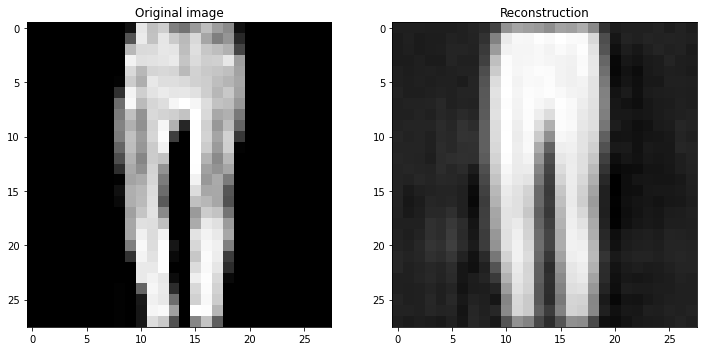

In [10]:
# Let's grab out a single image and label

x, _ = get_random_inputs(x_test, y_test, n=1)

preds, = net.predict(x)

# Plot everything!
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


ax1.set_title("Original image")
ax1.imshow(x[0].squeeze(), cmap="gray") 

ax2.set_title("Reconstruction")
ax2.imshow(preds.squeeze(), cmap="gray") 

plt.show()